In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras

In [2]:
%matplotlib inline
pd.set_option('max_columns', None)

In [3]:
palette = {'Cura': "C0", 'Obito': "C1"}

### Funções Auxiliares

In [4]:
def count_plot(dataset, x):
    
    sns.countplot(data=dataset, x=x, hue='EVOLUCAO', 
                  hue_order=['Cura','Obito'], palette=palette)
    
    plt.show()

### Pré-processamento

In [5]:
info_paciente = [
    'CS_SEXO', 
    'NU_IDADE_N', 
    'TP_IDADE',
    'CS_GESTANT',
    'UTI',
    'SUPORT_VEN',
    'CLASSI_FIN',
    'EVOLUCAO'
]

sintomas = [
    'FEBRE',
    'TOSSE',
    'GARGANTA',
    'DISPNEIA', 
    'DESC_RESP',
    'SATURACAO', 
    'DIARREIA',
    'VOMITO', 
    'DOR_ABD',
    'FADIGA',
    'PERD_OLFT', 
    'PERD_PALA'
]

fatores_de_risco = [
    'CARDIOPATI',
    'HEMATOLOGI',
    'SIND_DOWN',
    'HEPATICA',
    'ASMA',
    'DIABETES',
    'NEUROLOGIC',
    'PNEUMOPATI',
    'IMUNODEPRE',
    'RENAL',
    'OBESIDADE'
]

vacinas = [
    'DOSE_1_COV', 
    'DOSE_2_COV'
]

In [6]:
usecols2020 = info_paciente + sintomas + fatores_de_risco
usecols2021 = usecols2020 + vacinas

In [36]:
srag2020 = pd.read_csv('SRAG/INFLUD-29-11-2021.csv', usecols=usecols2020, sep=';')
srag2021 = pd.read_csv('SRAG/INFLUD21-29-11-2021.csv', usecols=usecols2021, sep=';')

In [37]:
srag = pd.concat([srag2020, srag2021], ignore_index=True)

In [38]:
srag.head()

,CS_SEXO,NU_IDADE_N,TP_IDADE,CS_GESTANT,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,UTI,SUPORT_VEN,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,DOSE_1_COV,DOSE_2_COV
0,M,1,3,6,1.0,1.0,2.0,9.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,M,7,2,6,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,F,57,3,5,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,M,9,2,6,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,M,1,3,6,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#Pacientes com covid e com evolucao definida
srag = srag[(srag['CLASSI_FIN'] == 5) & (srag['EVOLUCAO'].isin([1, 2]))]
srag = srag.drop(columns=['CLASSI_FIN'])

In [40]:
#Apenas idade em anos
srag = srag[srag['TP_IDADE'] == 3]
srag = srag.drop(columns=['TP_IDADE'])

In [41]:
#Remove gestantes
srag = srag[srag['CS_GESTANT'].isin([5, 6, 9])]
srag = srag.drop(columns=['CS_GESTANT'])

In [42]:
srag = srag[srag['CS_SEXO'] != 'I']

In [43]:
for column in vacinas:
    srag.loc[srag[column].notnull(), column] = 1
    srag.loc[srag[column].isnull(), column] = 0

In [44]:
for column in sintomas + fatores_de_risco:
    srag[column] = srag[column].replace({np.nan: 2, 9: 2})

In [45]:
for column in ['UTI', 'SUPORT_VEN']:
    srag = srag[srag[column] != 9] 

In [46]:
srag = srag.dropna()

In [47]:
srag.shape

(1363322, 30)

<AxesSubplot:>

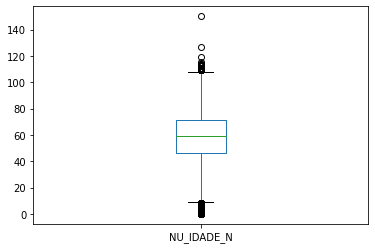

In [48]:
srag['NU_IDADE_N'].plot.box()

In [49]:
srag = srag[(srag['NU_IDADE_N'] > 0) & (srag['NU_IDADE_N'] <= 120)]

In [50]:
srag['EVOLUCAO'] = srag['EVOLUCAO'].replace({1: 'Cura', 2: 'Obito'})

In [51]:
last_columns = ['SUPORT_VEN', 'UTI', 'EVOLUCAO']

srag_last_columns = srag[last_columns]
srag = srag.drop(columns=last_columns)

In [52]:
srag = pd.concat([srag, srag_last_columns], axis=1, join="inner")

In [53]:
srag.head()

,CS_SEXO,NU_IDADE_N,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,DOSE_1_COV,DOSE_2_COV,SUPORT_VEN,UTI,EVOLUCAO
24,M,57,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Cura
32,M,79,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Obito
35,F,61,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Cura
38,F,92,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Obito
64,F,54,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,1.0,1.0,Obito


In [54]:
srag = srag.drop(columns=['TOSSE', 'GARGANTA', 'FADIGA', 'PERD_PALA', 'PERD_OLFT'])

In [55]:
srag.head()

,CS_SEXO,NU_IDADE_N,FEBRE,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,DOR_ABD,DOSE_1_COV,DOSE_2_COV,SUPORT_VEN,UTI,EVOLUCAO
24,M,57,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Cura
32,M,79,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Obito
35,F,61,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Cura
38,F,92,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0,0,2.0,2.0,Obito
64,F,54,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0,0,1.0,1.0,Obito


### Análise Exploratória

## EVOLUCAO

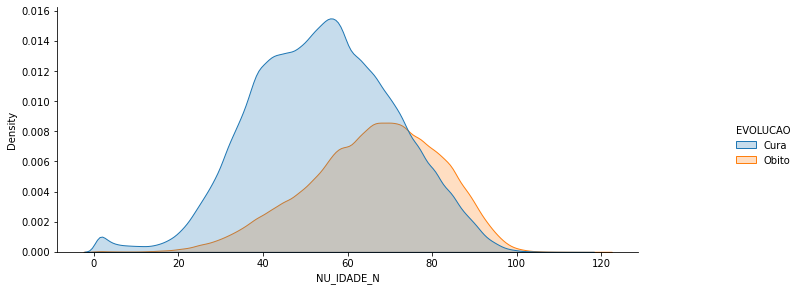

In [27]:
graph = sns.displot(srag, x='NU_IDADE_N', hue='EVOLUCAO', kind="kde", fill=True, palette=palette)
graph.fig.set_size_inches(12,4)
plt.show()

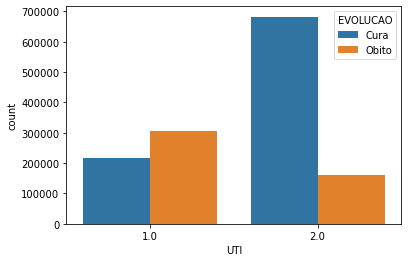

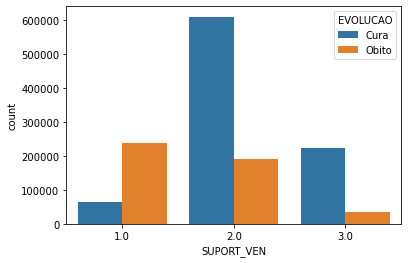

In [29]:
for info in ['UTI', 'SUPORT_VEN']:
    count_plot(srag, info)

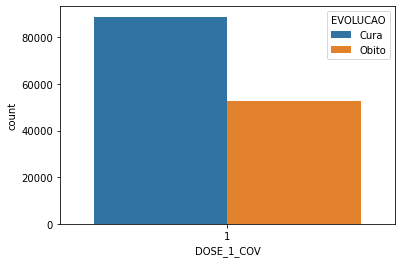

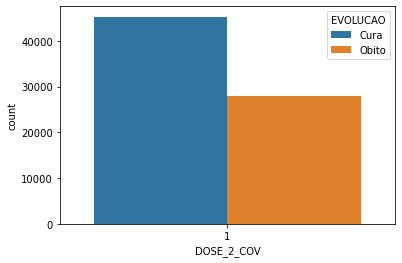

In [28]:
for vacina in vacinas:
    grupo = srag[srag[vacina] == 1]
    count_plot(grupo, vacina)

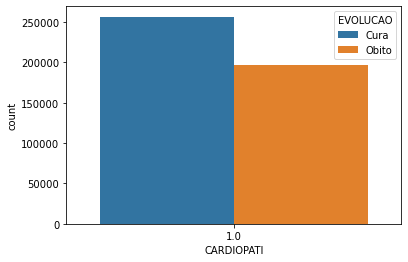

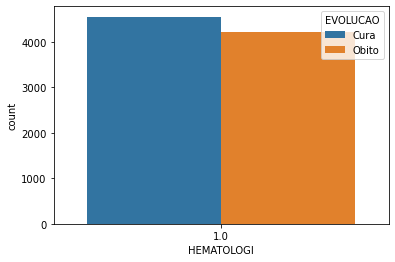

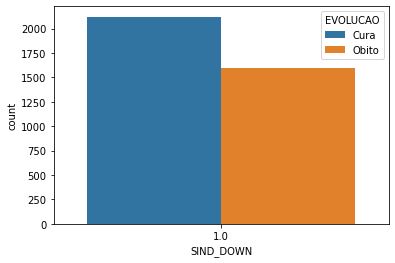

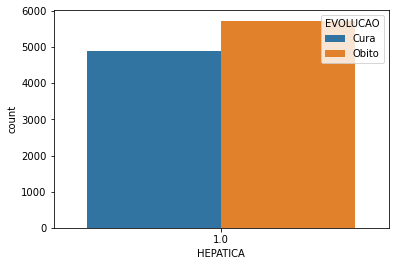

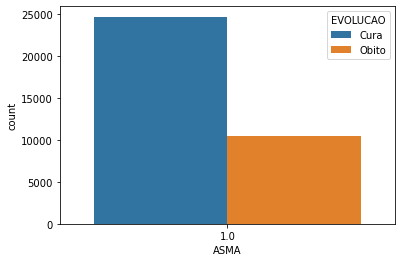

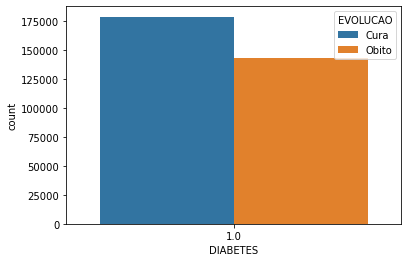

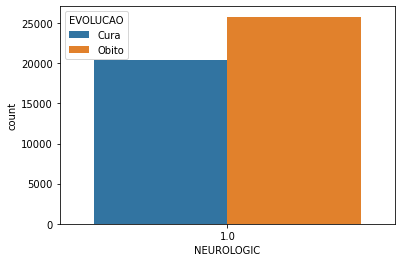

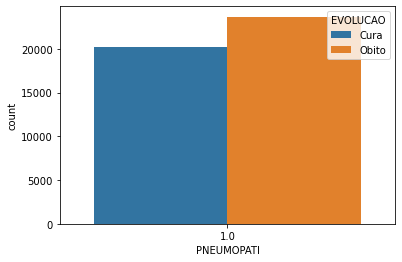

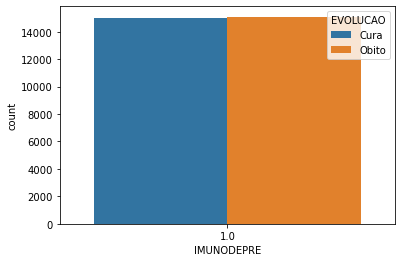

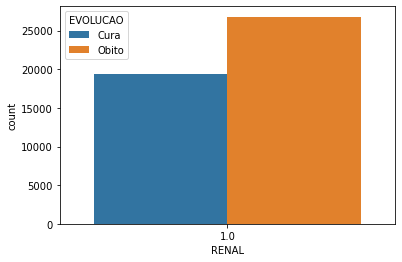

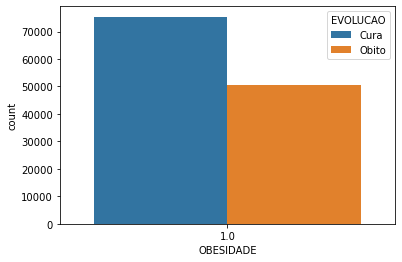

In [30]:
for fator in fatores_de_risco:
    grupo = srag[srag[fator] == 1]
    count_plot(grupo, fator)

### Balanceamento das Classes Alvo

In [56]:
srag['EVOLUCAO'].value_counts()/srag.shape[0]

Cura     0.659637
Obito    0.340363
Name: EVOLUCAO, dtype: float64

### Downsampling

In [57]:
# Serparação das classes minoritárias e majoritárias
srag_majority = srag[srag['EVOLUCAO'] == 'Cura']
srag_minority = srag[srag['EVOLUCAO'] == 'Obito']

# Tamanho da classe minoritária
minority_lenght = srag_minority.shape[0]

# Downsample da classe majoritária
majority_resampled = resample(
    srag_majority, 
    replace=False, # Downsampling sem reposição
    n_samples=minority_lenght, 
    random_state=42 # Seed 
) 
 
# Formação do dataset balanceado
balanced_srag = pd.concat([majority_resampled, srag_minority])

In [58]:
# Visualização do novo balanceamento
balanced_srag['EVOLUCAO'].value_counts()

Obito    464017
Cura     464017
Name: EVOLUCAO, dtype: int64

In [34]:
balanced_srag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928034 entries, 603977 to 2825164
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CS_SEXO     928034 non-null  object 
 1   NU_IDADE_N  928034 non-null  int64  
 2   FEBRE       928034 non-null  float64
 3   DISPNEIA    928034 non-null  float64
 4   DESC_RESP   928034 non-null  float64
 5   SATURACAO   928034 non-null  float64
 6   DIARREIA    928034 non-null  float64
 7   VOMITO      928034 non-null  float64
 8   CARDIOPATI  928034 non-null  float64
 9   HEMATOLOGI  928034 non-null  float64
 10  SIND_DOWN   928034 non-null  float64
 11  HEPATICA    928034 non-null  float64
 12  ASMA        928034 non-null  float64
 13  DIABETES    928034 non-null  float64
 14  NEUROLOGIC  928034 non-null  float64
 15  PNEUMOPATI  928034 non-null  float64
 16  IMUNODEPRE  928034 non-null  float64
 17  RENAL       928034 non-null  float64
 18  OBESIDADE   928034 non-null  float64
 

### Preparação dos Dados Para Modelos de Machine Learning

In [59]:
# Separação variáveis independentes e dependentes
X = balanced_srag.iloc[:, :-1].values
y = balanced_srag.iloc[:, -1].values

cat_features = [0, 20, 21]

column_transformer = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), cat_features)],
    remainder='passthrough'
)

X = np.array(column_transformer.fit_transform(X))

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(y)

# Devisão dos dados em teste e treino estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização dos dados
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

### CAT BOOST

In [60]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           depth=10)
# Fit model
model.fit(X_train, y_train)
# Get predicted classes
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0:	learn: 0.4852487	total: 169ms	remaining: 677ms
1:	learn: 0.4784071	total: 284ms	remaining: 426ms
2:	learn: 0.4762285	total: 429ms	remaining: 286ms
3:	learn: 0.4746808	total: 863ms	remaining: 216ms
4:	learn: 0.4737347	total: 1.06s	remaining: 0us
[[74281 18523]
 [22964 69839]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     92804
           1       0.79      0.75      0.77     92803

    accuracy                           0.78    185607
   macro avg       0.78      0.78      0.78    185607
weighted avg       0.78      0.78      0.78    185607



#### RANDOM FOREST

In [61]:
random_forest_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 25)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[71243 21561]
 [24849 67954]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     92804
           1       0.76      0.73      0.75     92803

    accuracy                           0.75    185607
   macro avg       0.75      0.75      0.75    185607
weighted avg       0.75      0.75      0.75    185607



In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 80)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#### DEEP LEARNING

In [ ]:
input_layer = X.shape[1]
input_layer

In [ ]:
tf.random.set_seed(2)

ann_classifier = keras.models.Sequential([
    keras.layers.Dense(units=input_layer, activation='relu'), 
    keras.layers.Dense(units=16, activation='softmax'),
    keras.layers.Dense(units=16, activation='softmax'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

ann_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

ann_classifier.fit(X_train, y_train, epochs = 150, verbose=True)

In [ ]:
y_pred = ann_classifier.predict(X_test) > 0.5

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
tf.random.set_seed(15)

ann_classifier = keras.models.Sequential([
    keras.layers.Dense(units=input_layer, activation='sigmoid'), 
    keras.layers.Dense(units=24, activation='sigmoid'),
    keras.layers.Dense(units=24, activation='sigmoid'),
    keras.layers.Dense(units=24, activation='sigmoid'),
    keras.layers.Dense(units=16, activation='sigmoid'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)


ann_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

ann_classifier.fit(X_train, y_train, epochs = 150, verbose=True)

In [ ]:
y_pred = ann_classifier.predict(X_test) > 0.5

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))